- Transfer learning -> last convoutional block
- Data Augmentation -> 200 samples per person (from 10 to 200 most cases)
- Train/test -> 70/30

In [1]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.
/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sol/.virtualenvs/maskrc

## Build model

In [2]:
set_size = 100   # amount of classes
epochs = 15
#train_percentage = 80

In [3]:
#Load the VGG model
img_width, img_height = 224, 224
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

W1030 19:02:01.201092 140520579196736 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1030 19:02:01.213592 140520579196736 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1030 19:02:01.216063 140520579196736 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1030 19:02:01.232782 140520579196736 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please us

In [4]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7fccf5f5e550> False
<keras.layers.convolutional.Conv2D object at 0x7fccf5f5e780> False
<keras.layers.convolutional.Conv2D object at 0x7fccf5f5e898> False
<keras.layers.pooling.MaxPooling2D object at 0x7fccf5708f98> False
<keras.layers.convolutional.Conv2D object at 0x7fccf5708ac8> False
<keras.layers.convolutional.Conv2D object at 0x7fcd03c20860> False
<keras.layers.pooling.MaxPooling2D object at 0x7fccf56dbd68> False
<keras.layers.convolutional.Conv2D object at 0x7fccf56db8d0> False
<keras.layers.convolutional.Conv2D object at 0x7fccf568a400> False
<keras.layers.convolutional.Conv2D object at 0x7fccf568acf8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fccf5646ac8> False
<keras.layers.convolutional.Conv2D object at 0x7fccf5646c50> False
<keras.layers.convolutional.Conv2D object at 0x7fccf5675780> False
<keras.layers.convolutional.Conv2D object at 0x7fccf5611ef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fccf5627f28>

In [5]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu', name='fc1'))
model.add(layers.Dense(4096, activation='relu', name='fc2'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(set_size, activation='softmax', name='predictions'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 100)               409700    
Total params: 134,670,244
Trainable params: 127,034,980
Non-trainable params: 7,635,264
_________________________________________________________________


In [6]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Save the model
#model.save('small_last4.h5')

W1030 19:02:05.612970 140520579196736 deprecation_wrapper.py:119] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Load data

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import csv

from sklearn.model_selection import train_test_split
from glob import glob
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [8]:
ROOT_DIR = os.path.abspath("../../")
DS_DIR = os.path.join(ROOT_DIR, "Datasets/awe_augmented/")

In [9]:
# Cantidad total de images 200 por persona
sample_per_person = 100
train_percentage = 70
train_size = round(sample_per_person*(train_percentage/100))
train_size, sample_per_person


(70, 100)

In [25]:
# Close-Set Experiments
# get X and y list
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []
for (dirpath, u_dirnames, filenames) in os.walk(DS_DIR):
    dirnames = sorted(u_dirnames)
    for i in range(0,len(dirnames)):
        FILE_DIR = os.path.join(DS_DIR, str(dirnames[i]))
        FILE_DIR = os.path.join(FILE_DIR, "da")
        files = glob(FILE_DIR+'/*.png') 
        print(len(files))
        if len(files) < sample_per_person:
            sample_per_person = len(files)
        for j in range (0,train_size):            
            image_class = int(str(dirnames[i]))-1
            img = image.load_img(files[j], target_size=(img_width, img_height))
            img_data = image.img_to_array(img)
            #img_data = preprocess_input(img_data)
            X_train_list.append(img_data)
            y_train_list.append(image_class)            
        for j in range (train_size,sample_per_person):            
            image_class = int(str(dirnames[i]))-1
            img = image.load_img(files[j], target_size=(img_width, img_height))
            img_data = image.img_to_array(img)
            #img_data = preprocess_input(img_data)
            X_test_list.append(img_data)
            y_test_list.append(image_class)            
    break

108
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
109
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
109
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
109
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
110
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
110
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
110
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
109
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
110
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
110
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
108
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
110
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
110
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
110
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
110
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
109
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*


In [10]:
# Open-Set Experiments
# get X and y list
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []
for (dirpath, u_dirnames, filenames) in os.walk(DS_DIR):
    dirnames = sorted(u_dirnames)
    for i in range(0,70):
        FILE_DIR = os.path.join(DS_DIR, str(dirnames[i]))
        FILE_DIR = os.path.join(FILE_DIR, "da")
        files = glob(FILE_DIR+'/*.png') 
        #print(len(files))
        #if len(files) < sample_per_person:
         #   sample_per_person = len(files)
        for j in range (0,sample_per_person):            
            image_class = int(str(dirnames[i]))-1
            img = image.load_img(files[j], target_size=(img_width, img_height))
            img_data = image.img_to_array(img)
            #img_data = preprocess_input(img_data)
            X_train_list.append(img_data)
            y_train_list.append(image_class) 
    for i in range(70,100):
        FILE_DIR = os.path.join(DS_DIR, str(dirnames[i]))
        FILE_DIR = os.path.join(FILE_DIR, "da")
        files = glob(FILE_DIR+'/*.png') 
        #print(len(files))
        #if len(files) < sample_per_person:
         #   sample_per_person = len(files)         
        for j in range (0,sample_per_person):            
            image_class = int(str(dirnames[i]))-1
            img = image.load_img(files[j], target_size=(img_width, img_height))
            img_data = image.img_to_array(img)
            #img_data = preprocess_input(img_data)
            X_test_list.append(img_data)
            y_test_list.append(image_class)            
    break

In [ ]:
#X = np.array(X_list)
#y = np.array(y_list)
#X.shape, y.shape, len(y)

In [ ]:
# Normalize data
#X = X /255.0


In [ ]:
#Split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [11]:
X_train = np.array(X_train_list)
X_test = np.array(X_test_list)
y_train = np.array(y_train_list)
y_test = np.array(y_test_list)

#Normalize
X_train = X_train/255.0
X_test = X_test/255.0

X_train.shape, X_test.shape, len(y_train), len(y_test)

((7000, 224, 224, 3), (3000, 224, 224, 3), 7000, 3000)

In [12]:
hist_y = np.zeros((101))
for i in range (0, len(y_train)):
    x = y_train[i]
    hist_y[x] += 1
sum(hist_y)

7000.0

In [13]:
hist_y

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.])

## Train model

In [14]:
model.fit(X_train, y_train, epochs=15)

W1030 19:04:52.320059 140520579196736 deprecation.py:323] From /home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
7000/7000 [==============================] - 62s 9ms/step - loss: 3.4584 - acc: 0.1779
Epoch 2/15
7000/7000 [==============================] - 51s 7ms/step - loss: 1.1579 - acc: 0.6777
Epoch 3/15
7000/7000 [==============================] - 50s 7ms/step - loss: 0.3235 - acc: 0.9033
Epoch 4/15
7000/7000 [==============================] - 50s 7ms/step - loss: 0.1627 - acc: 0.9563
Epoch 5/15
7000/7000 [==============================] - 50s 7ms/step - loss: 0.1148 - acc: 0.9684
Epoch 6/15
7000/7000 [==============================] - 50s 7ms/step - loss: 0.0925 - acc: 0.9746
Epoch 7/15
7000/7000 [==============================] - 50s 7ms/step - loss: 0.0755 - acc: 0.9809
Epoch 8/15
7000/7000 [==============================] - 50s 7ms/step - loss: 0.0789 - acc: 0.9821
Epoch 9/15
7000/7000 [==============================] - 50s 7ms/step - loss: 0.0805 - acc: 0.9806
Epoch 10/15
7000/7000 [==============================] - 50s 7ms/step - loss: 0.0768 - acc: 0.9849
Epoch 11/15
7000/70

In [39]:
# Close-set experiments
# Train and test with pixel-segmented ears
# 25 epochs
# fc2 output size = 4096
# Trained on 70% AWESegScores
# With data augmentation -> 100 samples per person 
# 7000 samples to train - 3000 samples to test
# With data normalization
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3000/3000 [==============================] - 13s 4ms/step
Test accuracy: 0.7076666668256124


In [18]:
# Close-set experiments
# Train and test with pixel-segmented ears
# 15 epochs
# fc2 output size = 4096
# Trained on 70% AWESegScores
# Without data augmentation -> 10 samples per person
# With data normalization
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

188/188 [==============================] - 1s 5ms/step
Test accuracy: 0.1276595747851311


In [27]:
# Close-set experiments
# Train and test with bounding_box-segmented ears
# 25 epochs
# fc2 output size = 4096
# Trained on 70% AWESegScores
# With data augmentation -> 100 samples per person 
# 7000 samples to train - 3000 samples to test
# With data normalization
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3000/3000 [==============================] - 16s 5ms/step
Test accuracy: 0.7966666668256124


In [27]:
# Open-set experiments
# Train and test with bounding_box-segmented ears
# 25 epochs
# fc2 output size = 4096
# Trained on 70% AWESegScores
# With data augmentation -> 100 samples per person 
# 7000 samples to train - 3000 samples to test
# With data normalization
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3000/3000 [==============================] - 16s 5ms/step
Test accuracy: 0.7966666668256124


In [26]:
# Close-set experiments
# Train and test with pixel-segmented ears
# 15 epochs
# fc2 output size = 4096
# Trained on 70% AWESegScores
# Without data normalization
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

188/188 [==============================] - 1s 4ms/step
Test accuracy: 0.07446808526490598


In [33]:
#10 epochs
# fc2 output size = 4096
# Trained on CVLEDB + AMI Datasets
# 90% to train and 10% to test
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

1740/1740 [==============================] - 8s 5ms/step
Test accuracy: 0.9597701150795509


In [14]:
#10 epochs
# fc2 output size = 1024
# Trained on CVLEDB + AMI Datasets
# 90% to train and 10% to test
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

1740/1740 [==============================] - 8s 5ms/step
Test accuracy: 0.9448275860698744


## Use model as feature extractor

In [34]:
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

In [35]:
model_extractor = Model(input=model.input, output=model.get_layer('fc2').output)
model_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
Total params: 134,260,544
Trainable params: 126,625,280
Non-trainable params: 7,635,264
_________________________________________________________________


/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("vg..., outputs=Tensor("fc...)`
  """Entry point for launching an IPython kernel.


In [36]:
ROOT_DIR = os.path.abspath("../../")
DS_DIR = os.path.join(ROOT_DIR, "Datasets/awe/")

In [37]:
vgg16_feature_list = []
for (dirpath, u_dirnames, filenames) in os.walk(DS_DIR):
    dirnames = sorted(u_dirnames)
    for i in range(0,len(dirnames)):
        FILE_DIR = os.path.join(DS_DIR, str(dirnames[i]))
        #FILE_DIR = os.path.join(FILE_DIR, "da")
        files = glob(FILE_DIR+'/*.png') 
        for j in range (0,len(files)):
            #print(files[j])
            image_class = np.array([int(str(dirnames[i]))])
            img = image.load_img(files[j], target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)
            
            fc2_features = model_extractor.predict(img_data)
            #vgg16_feature = model.predict(img_data)
            image_vector = np.array(fc2_features)            
            #image_vector = getVector()                       
            vgg16_feature_np = np.concatenate((image_class, image_vector[0]), axis=0)                                  
            vgg16_feature_list.append(vgg16_feature_np.flatten())            
    break

#print(len(vgg16_feature_list))
#print(len(vgg16_feature_np))
head = []
head.append('class')
for i in range(1, len(vgg16_feature_np)):
    head.append('v'+str(i))

head_np = []
head_np.append(head)
#print(head_np)

In [20]:
print(head_np)

[['class', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v58', 'v59', 'v60', 'v61', 'v62', 'v63', 'v64', 'v65', 'v66', 'v67', 'v68', 'v69', 'v70', 'v71', 'v72', 'v73', 'v74', 'v75', 'v76', 'v77', 'v78', 'v79', 'v80', 'v81', 'v82', 'v83', 'v84', 'v85', 'v86', 'v87', 'v88', 'v89', 'v90', 'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109', 'v110', 'v111', 'v112', 'v113', 'v114', 'v115', 'v116', 'v117', 'v118', 'v119', 'v120', 'v121', 'v122', 'v123', 'v124', 'v125', 'v126', 'v127', 'v128', 'v129', 'v130', 'v131', 'v132', 'v133', 'v134', 'v135', 'v136', 'v137', '

In [38]:
with open('vgg16_trained_cvledb_plus_ami_tested_awe_4096.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(head_np)
    writer.writerows(vgg16_feature_list)
csvFile.close()

## Get metric

In [22]:
def chiSquared(a,b):
    res = np.sqrt(0.5*np.sum((a-b)**2/(a+b+1e-6)))
    return res

def chiSquared2(a,b):
    #res = np.sqrt(0.5*np.sum((a-b)**2/(a+b+1e-6)))
    return 0.5*np.sum((a-b)**2/(a+b+1e-6))

#Input: csvfile // Output: rankbins
def getMetrics(csvfilename, rank):
    data = pd.read_csv(csvfilename)
    Xdf = data.drop('class', axis=1)  
    ydf = data['class']
    X = Xdf.values
    y = ydf.values
    s = (len(X), len(X), 2)
    y_pred = np.zeros(s)
    
    # Get distances matrix
    for i in range(len(X)):        
        for j in range (len(X)):
            dis = chiSquared(X[i], X[j])
            y_pred[i][j] = [dis, y[j]] 
            
    # Order matrix acording to distance
    for i in range(len(y_pred)):
        b = y_pred[i]
        y_pred[i] = b[b[:,0].argsort()] 
        
    # Get Rank counting
    rankbins = np.zeros(rank+2)
    for i in range (len(y_pred)):        
        for j in range (len(y_pred)):
            if y_pred[i][j][0] == 0.0: #if distance is 0, it's the same vector                
                continue
            else:
                if j > rank: #we are interested in evaluate only the rank-n                    
                    rankbins[rank+1] += 1
                    break;
                else: 
                    if y[i] == y_pred[i][j][1]:                                                 
                        rankbins[j] += 1                        
                        break 
    
    rank_rate = rankbins/sum(rankbins)                
    return rank_rate

In [49]:
rate_nvgg16 = getMetrics("feature_vectors/vgg16_rt.csv", 15)
rate_nvgg16[1], np.sum(rate_nvgg16[:5])

(0.192, 0.349)

In [50]:
rate_vgg16 = getMetrics("feature_vectors/vgg16.csv", 15)
rate_vgg16[1], np.sum(rate_vgg16[:5])

(0.095, 0.21600000000000003)

In [24]:
rate_vgg16 = getMetrics("feature_vectors/vgg16_rt_da.csv", 15)
rate_vgg16[1], np.sum(rate_vgg16[:5])

(0.164, 0.294)

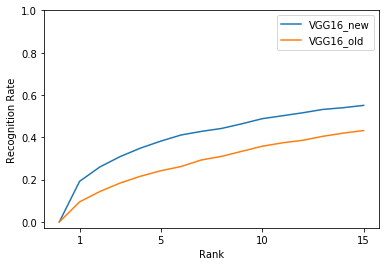

In [72]:
#plt.figure()
fig, ax = plt.subplots()
rate_vgg16_new, = plt.plot(np.cumsum(rate_nvgg16[0:16]))
rate_vgg16_old, = plt.plot(np.cumsum(rate_vgg16[0:16]))
#line_mobnet, = plt.plot(np.cumsum(rate_mobnet[0:16]))
plt.legend((rate_vgg16_new, rate_vgg16_old),
           ('VGG16_new', 'VGG16_old'))
plt.xlabel('Rank')
plt.ylabel('Recognition Rate') #for each component
ax.xaxis.set_ticks([1,5,10,15])
ax.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1])
#plt.title('Title')
plt.show()
#fig.savefig('Rank15_DL_2.png')

## Training a conv block

In [54]:
#Load the VGG model
img_width, img_height = 224, 224
vgg_conv2 = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [55]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv2.layers[:-8]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv2.layers:
    print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7fd3e0765198> False
<keras.layers.convolutional.Conv2D object at 0x7fd3e0765358> False
<keras.layers.convolutional.Conv2D object at 0x7fd3e07655c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd3e071fb38> False
<keras.layers.convolutional.Conv2D object at 0x7fd3e071fe80> False
<keras.layers.convolutional.Conv2D object at 0x7fd3e0636240> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd3e0636b38> False
<keras.layers.convolutional.Conv2D object at 0x7fd3e05d46a0> False
<keras.layers.convolutional.Conv2D object at 0x7fd3e05f4fd0> False
<keras.layers.convolutional.Conv2D object at 0x7fd3e0608940> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd3e05bdcf8> False
<keras.layers.convolutional.Conv2D object at 0x7fd3e05bdd30> True
<keras.layers.convolutional.Conv2D object at 0x7fd3e056d3c8> True
<keras.layers.convolutional.Conv2D object at 0x7fd3e056dcc0> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd3e0526a90> Tr

In [56]:
# Create the model
model2 = models.Sequential()
 
# Add the vgg convolutional base model
model2.add(vgg_conv)
 
# Add new layers
model2.add(layers.Flatten())
model2.add(layers.Dense(1024, activation='relu', name='fc1'))
model2.add(layers.Dense(1024, activation='relu', name='fc2'))
#model.add(layers.Dropout(0.5))
model2.add(layers.Dense(116, activation='softmax', name='predictions'))
 
# Show a summary of the model. Check the number of trainable parameters
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              25691136  
_________________________________________________________________
fc2 (Dense)                  (None, 1024)              1049600   
_________________________________________________________________
predictions (Dense)          (None, 116)               118900    
Total params: 41,574,324
Trainable params: 33,939,060
Non-trainable params: 7,635,264
_________________________________________________________________


In [57]:
# Compile the model
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Save the model
#model.save('small_last4.h5')

In [59]:
model2.fit(X_train, y_train, epochs=5)

Epoch 1/5
800/800 [==============================] - 4s 5ms/step - loss: 2.8106e-05 - acc: 1.0000
Epoch 2/5
800/800 [==============================] - 4s 5ms/step - loss: 1.5901e-05 - acc: 1.0000
Epoch 3/5
800/800 [==============================] - 4s 5ms/step - loss: 1.3045e-05 - acc: 1.0000
Epoch 4/5
800/800 [==============================] - 4s 5ms/step - loss: 0.3813 - acc: 0.9537
Epoch 5/5
800/800 [==============================] - 4s 6ms/step - loss: 0.0678 - acc: 0.9913


In [60]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

200/200 [==============================] - 1s 4ms/step
Test accuracy: 0.17


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

In [63]:
model_extractor2 = Model(input=model2.input, output=model2.get_layer('fc2').output)
model_extractor2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              25691136  
_________________________________________________________________
fc2 (Dense)                  (None, 1024)              1049600   
Total params: 41,455,424
Trainable params: 33,820,160
Non-trainable params: 7,635,264
_________________________________________________________________


/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("vg..., outputs=Tensor("fc...)`
  """Entry point for launching an IPython kernel.


In [71]:
rate_vgg16_2 = getMetrics("feature_vectors/vgg16_rt2.csv", 15)
rate_vgg16_2[1], np.sum(rate_vgg16_2[:5])

(0.183, 0.349)

/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fd3c3d750b8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  import sys
/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fd3c3c8b5f8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  import sys
/home/sol/.virtualenvs/maskrcnn/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fd3c3c8b748>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-

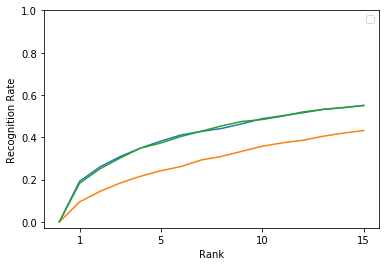

In [75]:
#plt.figure()
fig, ax = plt.subplots()
rate_vgg16_new = plt.plot(np.cumsum(rate_nvgg16[0:16]))
rate_vgg16_old = plt.plot(np.cumsum(rate_vgg16[0:16]))
rate_vgg16_new2 = plt.plot(np.cumsum(rate_vgg16_2[0:16]))
plt.legend((rate_vgg16_new, rate_vgg16_old, rate_vgg16_new2),
           ('VGG16_new', 'VGG16_old', 'VGG16_new2'))
plt.xlabel('Rank')
plt.ylabel('Recognition Rate') #for each component
ax.xaxis.set_ticks([1,5,10,15])
ax.yaxis.set_ticks([0,0.2,0.4,0.6,0.8,1])
#plt.title('Title')
plt.show()
#fig.savefig('Rank15_DL_2.png')